# Genetic Algorithm Weekly Trading Strategy — Beginner’s Deep Dive

---

## Table of Contents
1. What is a Genetic Algorithm? (Beginner’s Analogy)
2. Why Use GAs for Trading Strategies?
3. Step-by-Step: How This Script Works
    - 3.1. Setting the Stage: Parameters & Randomness
    - 3.2. Loading and Preparing Data
    - 3.3. Building Features: Turning Prices into Signals
    - 3.4. The GA Building Blocks: Rules, Mutation, Crossover
    - 3.5. The Evolution Loop: How Strategies Compete & Improve
    - 3.6. Measuring Success: Backtesting and Fitness
    - 3.7. Results, Visualization, and Next Steps
4. Error Handling, Robustness, and Reproducibility
5. Common Pitfalls & Practical Tips
6. Glossary
7. Further Reading

---

## 1. What is a Genetic Algorithm? (Beginner’s Analogy)

Imagine you’re trying to breed the fastest racehorse. You start with a bunch of horses (strategies), race them, and pick the fastest ones. Then you mix their genes (combine rules), sometimes introduce random changes (mutations), and repeat. Over time, you get faster horses.

A **Genetic Algorithm (GA)** is a computer method inspired by this process:
- **Population:** A group of candidate solutions (trading rules).
- **Selection:** Pick the best performers.
- **Crossover:** Combine parts of two good solutions to create new ones.
- **Mutation:** Randomly tweak parts of a solution to explore new possibilities.
- **Fitness:** A score measuring how good each solution is (e.g., how much money it makes, how risky it is).
- **Generations:** Repeat the process, letting the best solutions survive and evolve.

---

## 2. Why Use GAs for Trading Strategies?

- **Exploration:** Financial markets are complex. There are millions of possible rules for when to buy/sell. GAs help explore this huge space efficiently.
- **Adaptability:** GAs can discover creative, non-obvious strategies by combining and mutating rules.
- **Automation:** Instead of hand-crafting rules, let the algorithm search for you.

---

## 3. Step-by-Step: How This Script Works

### 3.1. Setting the Stage: Parameters & Randomness

```python
POP_SIZE, MAX_GENS = 120, 120
MUT_RATE, CROSS_RATE = 0.40, 0.40
TARGET_RET = 0.70
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
```
- **POP_SIZE:** Number of strategies (rules) in each generation (think: number of racehorses).
- **MAX_GENS:** How many generations (rounds of evolution) to run.
- **MUT_RATE/CROSS_RATE:** Controls how often mutation/crossover happens — keeps the search diverse.
- **TARGET_RET:** If a strategy achieves this return, stop early (success!).
- **RANDOM_SEED:** Ensures the experiment is repeatable (important for science and debugging).

### 3.2. Loading and Preparing Data

```python
CSV_PATH = r"...with_er_daily.csv"
df = pd.read_csv(CSV_PATH, parse_dates=True)
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors="coerce")
df = df.set_index(df.columns[0]).sort_index()
price_col = "cad_ig_er_index" if "cad_ig_er_index" in df.columns else df.columns[1]
price = df[price_col].resample("W-FRI").last().ffill()
df_w = price.to_frame("price")
df_w["ret_fwd"] = price.pct_change().shift(-1)
for col in ["cad_oas", "us_ig_oas", "us_hy_oas", "vix"]:
    df_w[col] = df[col].resample("W-FRI").last().ffill() if col in df.columns else 0.0
df_w = df_w.dropna(subset=["ret_fwd"])
```
- **Reads the data:** Loads daily market data from a CSV file.
- **Date handling:** Ensures the first column is a date and sorts it.
- **Resampling:** Converts daily prices to weekly (Friday close), filling missing values.
- **Forward return:** Calculates the return for the next week (used to judge if a rule is good).
- **Features:** Adds extra columns (OAS, VIX) if available, else fills with zeros (robust for missing data).

### 3.3. Building Features: Turning Prices into Signals

Features are like clues for the strategy — e.g., is the price trending up? Is volatility high?

```python
feat = pd.DataFrame(index=df_w.index)
for lag in [1,2,3,4,6,8,12,13,26,52]:
    feat[f"mom_{lag}"] = price.pct_change(lag)
for w in [4,8,13,26]:
    feat[f"vol_{w}"] = price.pct_change().rolling(w).std()
for w in [4,8,13,26]:
    feat[f"sma_{w}_dev"] = price/price.rolling(w).mean()-1
ema12, ema26 = price.ewm(span=12, adjust=False).mean(), price.ewm(span=26, adjust=False).mean()
feat["macd_diff"] = (ema12-ema26) - (ema12-ema26).ewm(span=9, adjust=False).mean()
low14, high14 = price.rolling(14).min(), price.rolling(14).max()
feat["stoch_k"] = 100*(price-low14)/(high14-low14+1e-8)
for col in ["cad_oas","us_ig_oas","us_hy_oas","vix"]:
    feat[f"{col}_mom4"] = df_w[col].pct_change(4)
feat = feat.fillna(0)
FEATURES = feat.columns.tolist()
```
- **Momentum:** How much the price has changed over various timeframes (1 to 52 weeks).
- **Volatility:** How much the price fluctuates (rolling standard deviation).
- **SMA Deviation:** How far the price is from its average (trend detection).
- **MACD Diff:** A popular momentum indicator.
- **Stochastic K:** Shows where the price is within its recent range (overbought/oversold).
- **OAS/VIX Momentum:** How much these risk indicators have changed recently.
- **NaN Handling:** Any missing values are filled with 0 (prevents errors later).

### 3.4. The GA Building Blocks: Rules, Mutation, Crossover

#### a. Creating a Random Clause
A **clause** is a simple rule like “momentum over 4 weeks is greater than X”.

```python
def rand_clause():
    f = random.choice(FEATURES)
    thr = np.percentile(feat[f], random.uniform(10,90))
    op  = ">" if random.random()<0.5 else "<"
    return f"(feat['{f}'] {op} {thr:.6f})"
```
- **Randomly picks a feature** (e.g., 4-week momentum).
- **Chooses a threshold** (between the 10th and 90th percentile of that feature’s values).
- **Randomly picks > or <** (greater or less than the threshold).
- **Returns a string** representing this clause.

#### b. Creating a Full Rule
A **rule** is a combination of clauses, joined by AND (`&`) or OR (`|`).

```python
def gen_rule(max_c=4):
    n = random.randint(1,max_c)
    join = " & " if random.random()<0.5 else " | "
    return join.join(rand_clause() for _ in range(n))
```
- **Chooses 1 to 4 clauses**.
- **Joins them** with AND (all must be true) or OR (any can be true).
- Example: `(feat['mom_4'] > 0.03) & (feat['vol_8'] < 0.02)`

#### c. Evaluating a Rule (Fitness)

```python
def evaluate(rule):
    try:
        mask = eval(rule)
        mask = mask.reindex(price.index).fillna(False)
        pf = vbt.Portfolio.from_signals(
            price,
            entries=mask,
            exits=~mask,
            freq='W',
            init_cash=10000,
            fees=0.0,
            slippage=0.0
        )
        ret = pf.total_return()
        dd = pf.max_drawdown()
        fitness = ret - 0.1*abs(dd)
        return fitness, ret, dd, pf
    except Exception as e:
        print(f"Error evaluating rule: {rule}\n{e}")
        return -1,-1,0,None
```
- **Evaluates the rule:** Turns the rule string into a series of True/False signals (when to be in the market).
- **Backtests:** Uses vectorbt to simulate trading (buy when rule is True, sell otherwise).
- **Measures performance:**
    - **Total return** (how much money made).
    - **Max drawdown** (biggest loss from a peak).
    - **Fitness:** Return minus 10% of drawdown (prefers high return, low risk).
- **Error Handling:** If the rule is invalid, prints the error and gives a bad score (so it won’t be selected).

#### d. Mutation (Random Change)

```python
def mutate(rule):
    if random.random()<0.5 and ("&" in rule or "|" in rule):
        parts = rule.split("&" if "&" in rule else "|")
        parts[random.randrange(len(parts))] = rand_clause()
        join = "&" if "&" in rule else "|"
        return join.join(p.strip() for p in parts)
    return f"({rule}) {'&' if random.random()<0.5 else '|'} {rand_clause()}"
```
- **With 50% chance:** Replaces a random clause in the rule.
- **Otherwise:** Adds a new clause with AND/OR.
- **Purpose:** Keeps the population diverse, helps discover new strategies.

#### e. Crossover (Breeding)

```python
def crossover(r1,r2):
    p1 = r1.split("&" if "&" in r1 else "|")
    p2 = r2.split("&" if "&" in r2 else "|")
    return random.choice(p1).strip()+" & "+random.choice(p2).strip()
```
- **Combines parts of two rules:** Takes a clause from each and joins with AND.
- **Purpose:** Mixes good ideas from different strategies.

### 3.5. The Evolution Loop: How Strategies Compete & Improve

This is where the magic happens. The algorithm runs for many generations, each time:
- **Evaluating all strategies** in the current population.
- **Selecting the best ones** (the “elite”).
- **Breeding new strategies** by mutation, crossover, or creating new random rules.
- **Replacing the population** with the new generation.

```python
pop=[gen_rule() for _ in range(POP_SIZE)]
best_rule,best_ret,best_pf=None,-1,None
for gen in range(MAX_GENS):
    scored=[(*evaluate(r)[:2],r) for r in pop]
    scored.sort(key=lambda x:x[0], reverse=True)
    elite=[r for _,_,r in scored[:25]]
    if scored[0][1]>best_ret:
        best_rule, best_ret = scored[0][2], scored[0][1]
        best_pf = evaluate(best_rule)[3]
        print(f"Gen {gen:03d}  best return {best_ret*100:5.1f}%")
        if best_ret>=TARGET_RET: break
    next_pop = elite.copy()
    while len(next_pop)<POP_SIZE:
        roll=random.random()
        if roll<MUT_RATE: next_pop.append(mutate(random.choice(elite)))
        elif roll<MUT_RATE+CROSS_RATE: next_pop.append(crossover(*random.sample(elite,2)))
        else: next_pop.append(gen_rule())
    pop=next_pop
```
- **Initial population:** Random rules.
- **For each generation:**
    - **Evaluate:** Score all rules.
    - **Sort:** Best to worst.
    - **Elite:** Top 25 rules survive.
    - **Track the best:** If new high score, save it and print progress.
    - **Early stop:** If target return is reached, break.
    - **Fill next population:**
        - By mutation, crossover, or new random rules.
- **Repeat:** Until max generations or target is reached.

### 3.6. Measuring Success: Backtesting and Fitness

- **Backtesting:** Simulates trading with each rule, using historical data.
- **Fitness:** Combines return and drawdown into a single score.
- **Selection:** Only the best (highest fitness) strategies survive to the next round.

### 3.7. Results, Visualization, and Next Steps

```python
if best_pf is not None:
    print("\nBest rule:", best_rule)
    print(f"Cumulative return {best_ret*100:.1f}%")
    print(best_pf.stats())
    best_pf.plot().show()
else:
    print("No valid solution found.")
```
- **Prints the best rule** and its performance.
- **Shows stats** (returns, drawdowns, etc.).
- **Plots the equity curve** (how your money would have grown).
- **Handles failure:** If no valid rule is found, prints a warning.

---

## 4. Error Handling, Robustness, and Reproducibility

- **Missing Data:** If features are missing, fills with zeros (prevents crashes).
- **Invalid Rules:** If a rule can’t be evaluated, prints the error and gives a low score.
- **NaNs:** All missing values filled with 0.
- **Random Seed:** Ensures you get the same results every run (unless you change the seed).
- **Logging:** Prints progress and errors for transparency.

---

## 5. Common Pitfalls & Practical Tips

- **Overfitting:** The GA may find rules that work great on historical data but fail in the future. Always test on unseen data.
- **Randomness:** Results can vary if you change the seed. Try multiple runs for robustness.
- **Complexity:** Simpler rules are often more robust. Too many clauses can overfit.
- **Interpretability:** The best rules may be hard to interpret. Consider adding constraints for clarity.

---

## 6. Glossary

- **Genetic Algorithm (GA):** A method inspired by evolution to search for good solutions.
- **Feature:** A numerical clue or signal derived from market data.
- **Clause:** A simple condition (e.g., momentum > 0.02).
- **Rule:** A combination of clauses (e.g., clause1 AND clause2).
- **Mutation:** Randomly changing part of a rule.
- **Crossover:** Combining parts of two rules.
- **Fitness:** Score measuring how good a rule is.
- **Backtest:** Simulate trading using historical data.
- **Drawdown:** Largest drop from a peak in portfolio value.
- **Elite:** The best-performing rules in a generation.

---

## 7. Further Reading

- [Wikipedia: Genetic Algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm)
- [vectorbt Documentation](https://vectorbt.dev/)
- [Quantitative Trading Strategies](https://www.investopedia.com/terms/q/quantitative-trading.asp)
- [Overfitting in Finance](https://www.investopedia.com/terms/o/overfitting.asp)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import vectorbt as vbt
import os

import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, itertools, random
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from deap import base, creator, tools, algorithms

import pandas as pd, numpy as np, random, time, matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore")   # to keep notebook output tidy



import pandas as pd
import numpy as np
import random
import vectorbt as vbt

# --- Parameters ---
POP_SIZE, MAX_GENS = 120, 120
MUT_RATE, CROSS_RATE = 0.40, 0.40
TARGET_RET = 0.70
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# --- Load the data ---
CSV_PATH = r"c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv"
df = pd.read_csv(CSV_PATH, parse_dates=True)
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors="coerce")
df = df.set_index(df.columns[0]).sort_index()
price_col = "cad_ig_er_index" if "cad_ig_er_index" in df.columns else df.columns[1]
price = df[price_col].resample("W-FRI").last().ffill()
df_w = price.to_frame("price")
df_w["ret_fwd"] = price.pct_change().shift(-1)
for col in ["cad_oas", "us_ig_oas", "us_hy_oas", "vix"]:
    df_w[col] = df[col].resample("W-FRI").last().ffill() if col in df.columns else 0.0
df_w = df_w.dropna(subset=["ret_fwd"])

# --- Feature matrix ---
feat = pd.DataFrame(index=df_w.index)
for lag in [1,2,3,4,6,8,12,13,26,52]:
    feat[f"mom_{lag}"] = price.pct_change(lag)
for w in [4,8,13,26]:
    feat[f"vol_{w}"] = price.pct_change().rolling(w).std()
for w in [4,8,13,26]:
    feat[f"sma_{w}_dev"] = price/price.rolling(w).mean()-1
ema12, ema26 = price.ewm(span=12, adjust=False).mean(), price.ewm(span=26, adjust=False).mean()
feat["macd_diff"] = (ema12-ema26) - (ema12-ema26).ewm(span=9, adjust=False).mean()
low14, high14 = price.rolling(14).min(), price.rolling(14).max()
feat["stoch_k"] = 100*(price-low14)/(high14-low14+1e-8)
for col in ["cad_oas","us_ig_oas","us_hy_oas","vix"]:
    feat[f"{col}_mom4"] = df_w[col].pct_change(4)
feat = feat.fillna(0)
FEATURES = feat.columns.tolist()

# --- GA primitives ---
def rand_clause():
    f = random.choice(FEATURES)
    thr = np.percentile(feat[f], random.uniform(10,90))
    op  = ">" if random.random()<0.5 else "<"
    return f"(feat['{f}'] {op} {thr:.6f})"

def gen_rule(max_c=4):
    n = random.randint(1,max_c)
    join = " & " if random.random()<0.5 else " | "
    return join.join(rand_clause() for _ in range(n))

def evaluate(rule):
    try:
        mask = eval(rule)
        mask = mask.reindex(price.index).fillna(False)
        # vectorbt backtest
        pf = vbt.Portfolio.from_signals(
            price,
            entries=mask,
            exits=~mask,
            freq='W',
            init_cash=10000,
            fees=0.0,
            slippage=0.0
        )
        ret = pf.total_return()
        dd = pf.max_drawdown()
        fitness = ret - 0.1*abs(dd)
        return fitness, ret, dd, pf
    except Exception as e:
        print(f"Error evaluating rule: {rule}\n{e}")
        return -1,-1,0,None

def mutate(rule):
    if random.random()<0.5 and ("&" in rule or "|" in rule):
        parts = rule.split("&" if "&" in rule else "|")
        parts[random.randrange(len(parts))] = rand_clause()
        join = "&" if "&" in rule else "|"
        return join.join(p.strip() for p in parts)
    return f"({rule}) {'&' if random.random()<0.5 else '|'} {rand_clause()}"

def crossover(r1,r2):
    p1 = r1.split("&" if "&" in r1 else "|")
    p2 = r2.split("&" if "&" in r2 else "|")
    return random.choice(p1).strip()+" & "+random.choice(p2).strip()

# --- Run GA ---
pop=[gen_rule() for _ in range(POP_SIZE)]
best_rule,best_ret,best_pf=None,-1,None
for gen in range(MAX_GENS):
    scored=[(*evaluate(r)[:2],r) for r in pop]
    scored.sort(key=lambda x:x[0], reverse=True)
    elite=[r for _,_,r in scored[:25]]
    if scored[0][1]>best_ret:
        best_rule, best_ret = scored[0][2], scored[0][1]
        best_pf = evaluate(best_rule)[3]
        print(f"Gen {gen:03d}  best return {best_ret*100:5.1f}%")
        if best_ret>=TARGET_RET: break
    next_pop = elite.copy()
    while len(next_pop)<POP_SIZE:
        roll=random.random()
        if roll<MUT_RATE: next_pop.append(mutate(random.choice(elite)))
        elif roll<MUT_RATE+CROSS_RATE: next_pop.append(crossover(*random.sample(elite,2)))
        else: next_pop.append(gen_rule())
    pop=next_pop

# --- Metrics & plot ---
if best_pf is not None:
    print("\nBest rule:", best_rule)
    print(f"Cumulative return {best_ret*100:.1f}%")
    print(best_pf.stats())
    best_pf.plot().show()
else:
    print("No valid solution found.")


Gen 000  best return  66.3%
Gen 001  best return  71.9%

Best rule: (feat['us_hy_oas_mom4'] < 0.062418) & (feat['cad_oas_mom4'] < 0.063111)
Cumulative return 71.9%
Start                                2003-12-05 00:00:00
End                                  2025-06-06 00:00:00
Period                                7861 days 00:00:00
Start Value                                      10000.0
End Value                                   17187.728538
Total Return [%]                               71.877285
Benchmark Return [%]                           32.036884
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                                1.594127
Max Drawdown Duration                  441 days 00:00:00
Total Trades                                          84
Total Closed Trades                                   84
Total Open Trades                                      0
Open Trade PnL                        


--- QuantStats Full Report (Strategy vs Buy & Hold) ---



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2003-12-12   2003-12-12
End Period                 2025-06-06   2025-06-06
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       72.0%

Cumulative Return          32.04%       71.88%
CAGR﹪                     0.9%         1.75%

Sharpe                     1.35         4.38
Prob. Sharpe Ratio         99.26%       100.0%
Smart Sharpe               1.02         3.3
Sortino                    1.76         9.2
Smart Sortino              1.33         6.93
Sortino/√2                 1.25         6.5
Smart Sortino/√2           0.94         4.9
Omega                      3.05         3.05

Max Drawdown               -15.38%      -1.59%
Longest DD Days            1422         435
Volatility (ann.)          4.71%        2.79%
R^2                        0.38         0.38
Information Ratio          0.1          0.1
Calmar                     0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-24,2020-05-15,2020-05-29,127,-1.594127,-1.345395
2,2009-02-27,2009-03-06,2009-04-10,43,-1.486241,-1.040697
3,2007-03-02,2008-04-18,2008-05-09,435,-1.129407,-1.097884
4,2011-02-25,2011-10-21,2011-10-21,239,-0.886509,-0.690577
5,2022-04-08,2022-06-17,2022-11-18,225,-0.862970,-0.833145


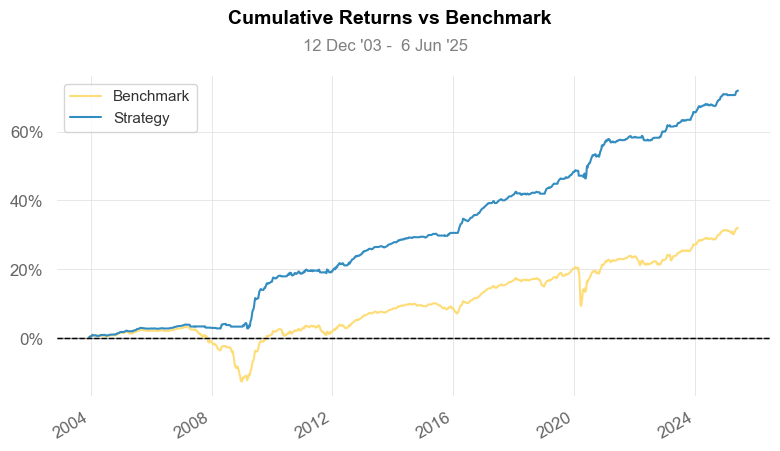

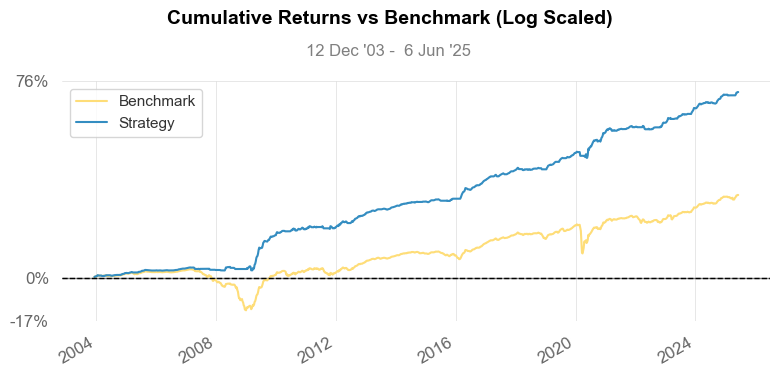

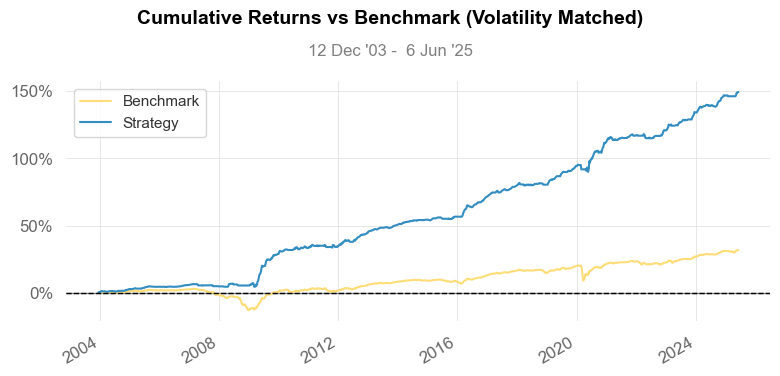

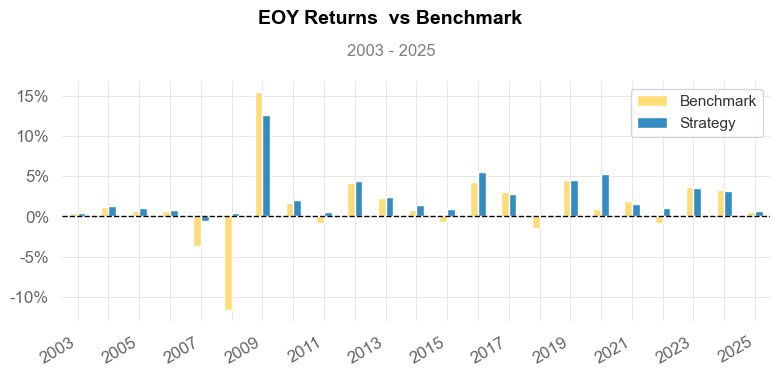

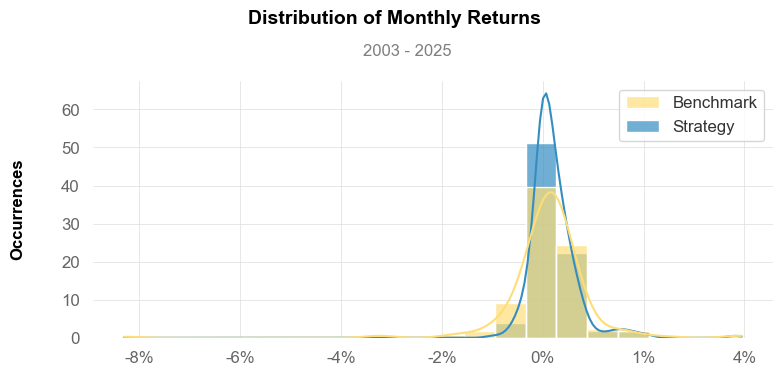

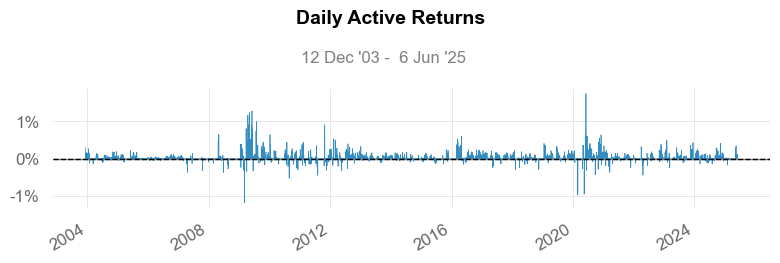

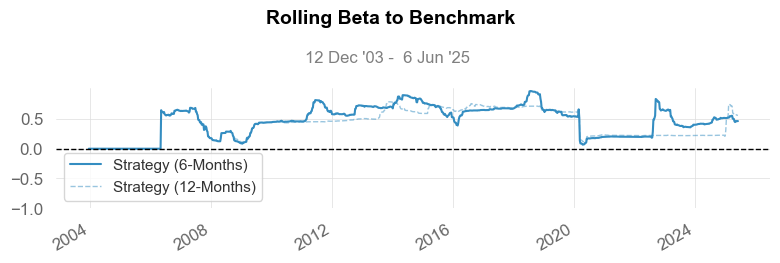

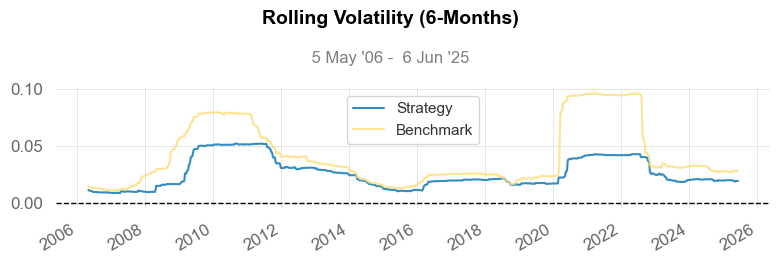

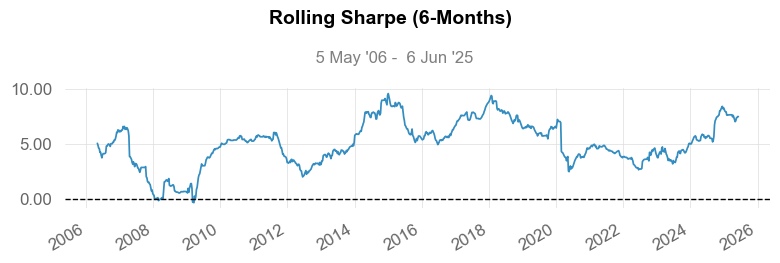

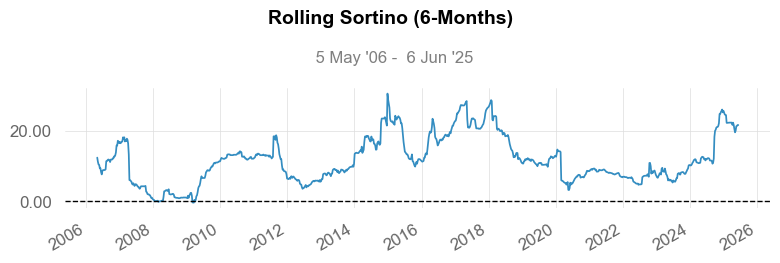

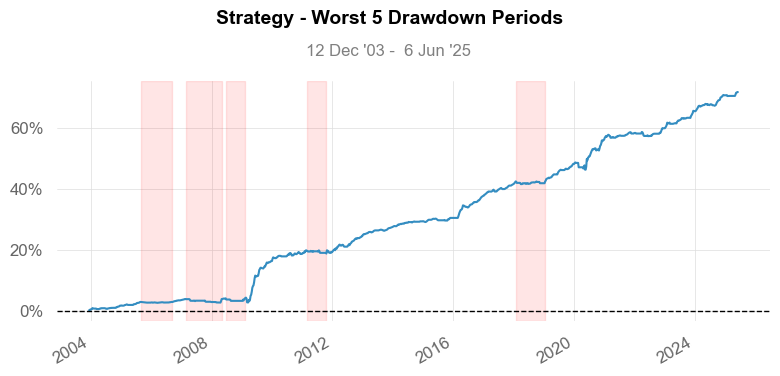

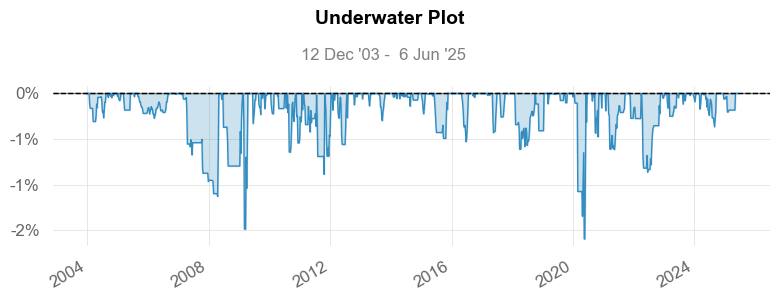

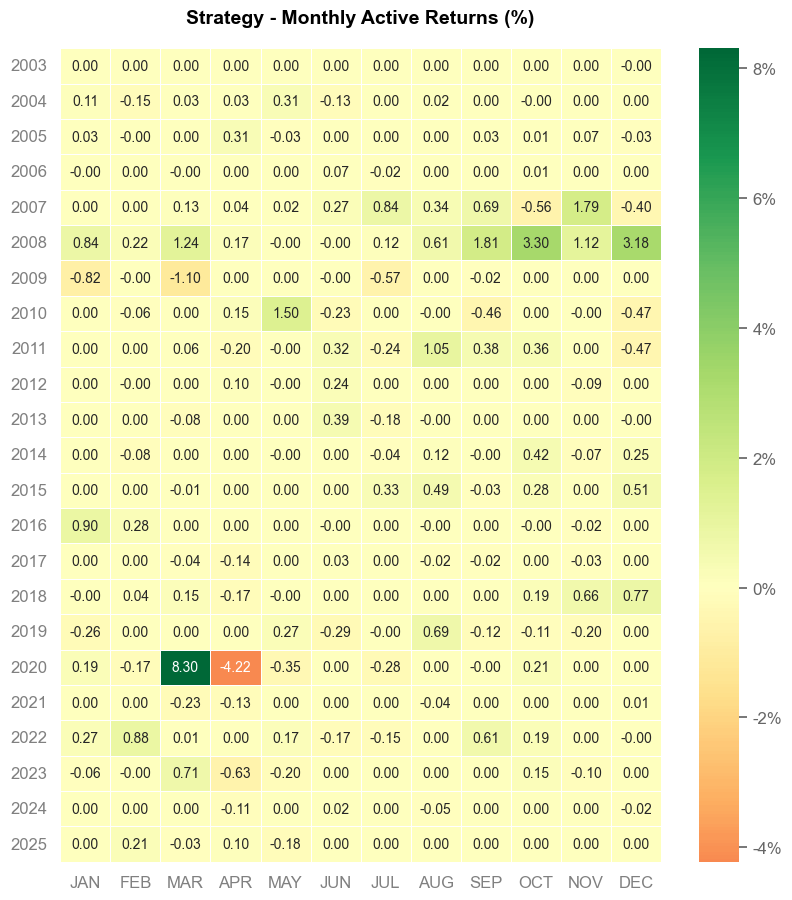

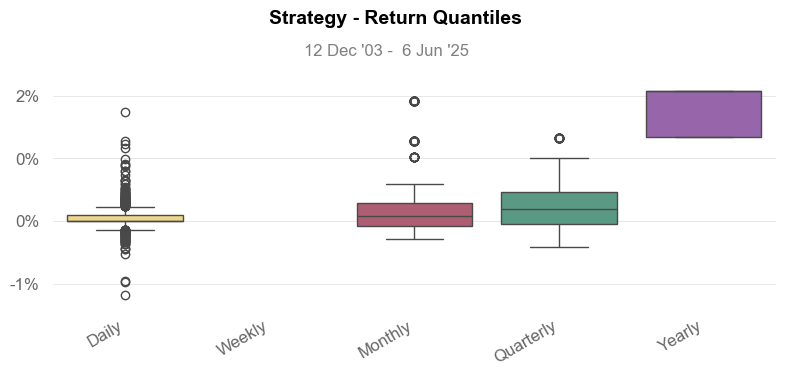

Strategy vs Buy and Hold tearsheet saved to: tearsheets\Genetic_Algo_Weekly_vs_BuyHold.html


In [2]:
# --- QuantStats Backtest & Report for Genetic Algorithm Strategy ---

import os
import quantstats as qs
import numpy as np

# 1. Ensure the output directory exists
output_dir = 'tearsheets'
os.makedirs(output_dir, exist_ok=True)
output_path_ga = os.path.join(output_dir, 'Genetic_Algo_Weekly_vs_BuyHold.html')

# 2. Get the strategy's returns from the best GA portfolio
strategy_returns = best_pf.returns()
if strategy_returns is None or len(strategy_returns) == 0:
    print("No valid strategy returns found. QuantStats report will not be generated.")
else:
    # 3. Prepare the benchmark (buy-and-hold) returns
    benchmark_returns = price.pct_change().reindex(strategy_returns.index).fillna(0)
    benchmark_returns = benchmark_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # 4. Generate the full QuantStats tearsheet with benchmark comparison (in-notebook)
    print("\n--- QuantStats Full Report (Strategy vs Buy & Hold) ---\n")
    qs.reports.full(
        strategy_returns,
        benchmark=benchmark_returns,
        title='Genetic Algorithm Weekly vs Buy and Hold',
        freq='W'
    )

    # 5. Save the HTML report for later review or sharing
    qs.reports.html(
        strategy_returns,
        benchmark=benchmark_returns,
        output=output_path_ga,
        title='Genetic Algorithm Weekly vs Buy and Hold',
        freq='W'
    )
    print(f"Strategy vs Buy and Hold tearsheet saved to: {output_path_ga}")

# --- End QuantStats Block ---